# BioBuilder API Demo

In [1]:
import sys

sys.path.insert(0, '..')

import os
import requests

caravagna_model_filepath = '../biosimulator_processes/model_files/Caravagna2010.xml'
print(os.path.exists(caravagna_model_filepath))

tumor_control_biomodel_id = 'BIOMD0000000749'
requests.get('https://www.ebi.ac.uk/biomodels/BIOMD0000000749', headers={'accept': 'json'})

True


<Response [200]>

#### **_Experiment 1_**:  Here we cross a boundary in the stack that is a biological simulation. We go from model configuration, to experiment. Thus, this tooling sits at that level: both experiment specification AND experiment execution. It's not just a way to specify an experiment, but it is also a way to run it, given the many knobs and buttons that you can use predefine and customize the way the actual model is being solved. Our users are seeking to be involved in an experiment as a "stack". We should make a bigger distinction between terms like "model".

In [2]:
from process_bigraph import pp
from biosimulator_processes.biosimulator_builder import BuildPrompter
from biosimulator_processes.data_model import TimeCourseProcess, TimeCourseModel

CobraProcess registered successfully.
CopasiProcess registered successfully.
SmoldynProcess registered successfully.
TelluriumProcess registered successfully.


In [3]:
# 1a. define a model for the process composition. In this case, just one model to be re-used as configuration for the processes we create:

tc_model = TimeCourseModel(model_source=tumor_control_biomodel_id)

pp(tc_model)

TimeCourseModel(model_source='BIOMD0000000749',
                model_id='model_from_BIOMD0000000749',
                model_name='model_from_BIOMD0000000749',
                model_language='sbml',
                model_changes=None,
                model_units=None)


In [4]:
# 1b. define a TimeCourse process instance using the above object as a parameter. The other parameter is method. See BasiCO documentation for more details on solvers

tc_process = TimeCourseProcess(model=tc_model, method='hybridlsoda')

In [5]:
# >> The process model instance is viewable as a dataclass...

pp(tc_process)

TimeCourseProcess(model=TimeCourseModel(model_source='BIOMD0000000749',
                                        model_id='model_from_BIOMD0000000749',
                                        model_name='model_from_BIOMD0000000749',
                                        model_language='sbml',
                                        model_changes=None,
                                        model_units=None),
                  method='hybridlsoda')


In [6]:
# >> ...or a dict:

pp(tc_process.to_dict())

{ 'method': 'hybridlsoda',
  'model': { 'model_changes': None,
             'model_id': 'model_from_BIOMD0000000749',
             'model_language': 'sbml',
             'model_name': 'model_from_BIOMD0000000749',
             'model_source': 'BIOMD0000000749',
             'model_units': None}}


In [7]:
# 2. instantiate the prompter:

prompter = BuildPrompter()

In [8]:
# 3. add process(es) to the bigraph with the Time Course model instance we created above. For now, just one process will be added.

prompter.add_single_process(config=tc_process)

tumor_control_model_composite process successfully added to the bi-graph!
All nodes including the most recently added tumor_control_model_composite processes connected!
Done adding single tumor_control_model_composite (CopasiProcess) to the bigraph.


In [9]:
# 4. Inspect the builder instance within prompter:

pp(prompter.builder_instance)

Builder({ 'emitter': { '_type': 'step',
               'address': 'local:ram-emitter',
               'config': {'emit': {}},
               'inputs': {},
               'instance': <process_bigraph.composite.RAMEmitter object at 0x29b03a6b0>,
               'outputs': {}},
  'tumor_control_model_composite': { '_type': 'process',
                                     'address': 'local:CopasiProcess',
                                     'config': { 'method': 'hybridlsoda',
                                                 'model': { 'model_changes': { 'global_parameter_changes': None,
                                                                               'reaction_changes': None,
                                                                               'species_changes': None},
                                                            'model_id': 'model_from_BIOMD0000000749',
                                                            'model_language': 'sbml',
            

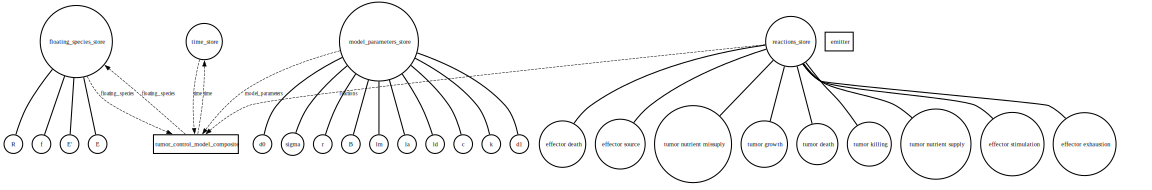

In [10]:
# 5. Visualize the fully-connected composition:

prompter.visualize_bigraph()

In [11]:
# 6. Generate a composite engine and use to execute the bigraph that we just created:

prompter.run()

Error while running the simulation: >ERROR 2024-03-14T20:04:46<
  CCopasiTask (5): No output file defined for report of task 'Time-Course'.>EXCEPTION 2024-03-14T20:04:46<
  CTrajectoryMethod (25): Invalid state at time '0.010000'.
/Users/alex/Desktop/uchc_work/repos/biosimulator-processes/notebooks/../biosimulator_processes/processes/copasi_process.py:231: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Error while running the simulation: >ERROR 2024-03-14T20:04:46<
  CCopasiTask (5): No output file defined for report of task 'Time-Course'.>EXCEPTION 2024-03-14T20:04:46<
  CTrajectoryMethod (25): Invalid state at time '0.010000'.
Error while running the simulation: >ERROR 2024-03-14T20:04:46<
  CCopasiTask (5): No output file defined for report of task 'Time-Course'.>EXCEPTION 2024-03-14T20:04:46<
  CTr

Generating composite...
Composite generated!
Running generated composite for an interval of 5
Composite successfully run. Request complete. Done.


In [15]:
# 6. Save the composite to a document:

prompter.builder_instance.write(filename='demo_tumor_control_composite')

File 'demo_tumor_control_composite' successfully written in 'out' directory.


#### **_Experiment 2_**: Load an SBML model from a specified model filepath and add Model changes to the composite before adding it to the bigraph.

In [16]:
from biosimulator_processes.data_model import TimeCourseModelChanges, ModelChanges, ModelChange